# Derivation of the inversion stencil using a non-symmetric forward-backward scheme

Derivation of a non-symmetric stencil of 

$$b = \nabla\cdot(A\nabla_\perp f)+Bf$$

using a forward stencil on $\nabla\cdot(A\nabla_\perp f)$, and a backward stencil on $\nabla_\perp f$.

The stencil will not be symmetric as $f(x-h_x)$, $f(x)$ and $f(x+h_x)$ would be multiplied with $J(x,y)$. Symmetry requires that $f(x-h_x)$ is multiplied with $J(x-h_x)$, $f(x)$ with $J(x)$ and $f(x+h_x)$ with $J(x+h_x)$.

For symmetric version, see [ForwardsBackwards.ipynb](ForwardsBackwards.ipynb) and [BackwardsForwards.ipynb](BackwardsForwards.ipynb)

In [1]:
from IPython.display import display
from sympy import init_printing
from sympy import symbols, expand, together, as_finite_diff, collect
from sympy import Function, Eq, Subs
from collections import deque

init_printing()

In [2]:
def finiteDifferenceOfOneTerm(factors, wrt, stencil):
    """
    Finds the finite different approximation of a term consisting of several factors
    
    Input:
    factors - An iterable containing the factors of the term
    wrt     - Take the derivative of the term with respect to this variable
    stencil - An iterable containing the points to be used in the stencil
    
    Output
    term - The finite difference approximation of the term
    """
    # Take the derivative
    factorsDiff = []
    for factor in factors:
        factorsDiff.append(as_finite_diff(factor.diff(wrt), stencil))
    
    # Putting together terms
    term = 0
    # Make object for cyclic permutation
    cyclPerm = deque(range(len(factors)))
    for perm in range(len(cyclPerm)):
        # Initialize a dummy term to store temporary variables in
        curTerm = factorsDiff[cyclPerm[0]]
        for permNr in range(1,len(factors)):
            curTerm *= factors[cyclPerm[permNr]]
        # Make a cyclic premutation
        cyclPerm.rotate(1)
        term += curTerm
    return term

In [3]:
def fromFunctionToGrid(expr, sym):
    """
    Change from @(x,z) to @_xz, where @ represents a function
    
    Input:
    expr - The expression to change
    sym  - symbols('@_xz, @_xp1z, @_xm1z, @_xzp1, @_xzm1')
           xp1 = x+hx
           zm1 = z-hz
           etc.
    """
    curFun = str(syms[0]).split('_')[0]
    for sym in syms:
        curSuffix = str(sym).split('_')[1]
        if curSuffix == 'xz':
            expr = expr.subs(Function(curFun)(x,z), sym)
        elif curSuffix == 'xp1z':
            expr = expr.subs(Subs(Function(curFun)(x,z), x, x+hx).doit(), sym)
        elif curSuffix == 'xm1z':
            expr = expr.subs(Subs(Function(curFun)(x,z), x, x-hx).doit(), sym)
        elif curSuffix == 'xzp1':
            expr = expr.subs(Subs(Function(curFun)(x,z), z, z+hz).doit(), sym)
        elif curSuffix == 'xzm1':
            expr = expr.subs(Subs(Function(curFun)(x,z), z, z-hz).doit(), sym)

    return expr

In [4]:
x, z, hx, hz = symbols('x, z, h_x, h_z')
hx, hz = symbols('h_x, h_z', positive=True)

f = Function('f')(x, z)
A = Function('A')(x, z)
B = Function('B')(x, z)
gxx = Function('g^x^x')(x, z)
gzz = Function('g^z^z')(x, z)
J = Function('J')(x, z)

# Dummy function
g = Function('g')(x,z)

# Stencils
backwardX = [x-hx, x]
forwardX  = [x, x+hx]
backwardZ = [z-hz, z]
forwardZ  = [z, z+hz]

We are here discretizing the equation

$$ b =
\nabla\cdot(A\nabla_\perp f)+Bf
\simeq
\frac{1}{J}\partial_x \left(JAg^{xx}\partial_x f\right)
+ \frac{1}{J}\partial_z \left(JAg^{zz}\partial_z f\right) + Bf$$

where the derivatives in $y$ has been assumed small in non-orthogonal grids.

We will let $T$ denote "term", the superscript $^F$ denote a forward stencil, and the superscript $^B$ denote a backward stencil.

**NOTE:**

`sympy` has a built in function `as_finite_diff`, which could do the derivation easy for us. However it fails if

* Non derivative terms or factors are present in the expression
* If the expression is a `Subs` object (for example unevaluated derivatives calculated at a point)

We therefore do this in a sligthly tedious way.

## Calculating the first term

### Calculate the finite difference approximation of $\partial_x f$

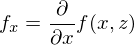

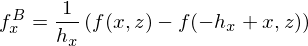

In [5]:
fx = f.diff(x)
fxB = as_finite_diff(fx, backwardX)
display(Eq(symbols('f_x'), fx))
display(Eq(symbols('f_x^B'), together(fxB)))

### Calculate the finite difference approximation of $\frac{1}{J}\partial_x \left(JAg^{xx}\partial_x f\right)$

We start by making the substitution $\partial_x f \to g$ and calulate the first term of the equation under consideration

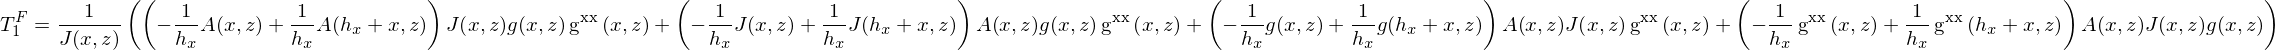

In [6]:
# Define the factors
factors = [J, A, gxx, g]
term1 = finiteDifferenceOfOneTerm(factors, x, forwardX)
term1 /= J
display(Eq(symbols('T_1^F'), term1))

We now back substitute $g\to \partial_x f$

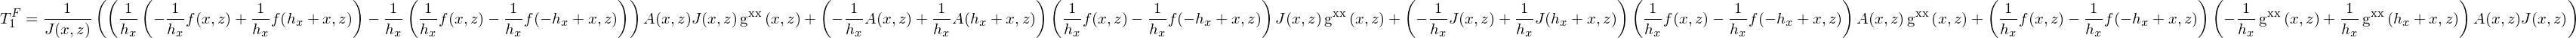

In [7]:
term1 = term1.subs(Subs(g,x,x+hx).doit(), Subs(fxB,x,x+hx).doit())
term1 = term1.subs(g, fxB)
display(Eq(symbols('T_1^F'), term1))

## Calculating the second term

### Calculate the finite difference approximation of $\partial_z f$

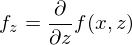

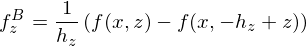

In [8]:
fz = f.diff(z)
fzB = as_finite_diff(fz, backwardZ)
display(Eq(symbols('f_z'), fz))
display(Eq(symbols('f_z^B'), together(fzB)))

### Calculate the finite difference approximation of $\frac{1}{J}\partial_z \left(JAg^{zz}\partial_z f\right)$

We start by making the substitution $\partial_z f \to g$ and calulate the second term of the equation under consideration

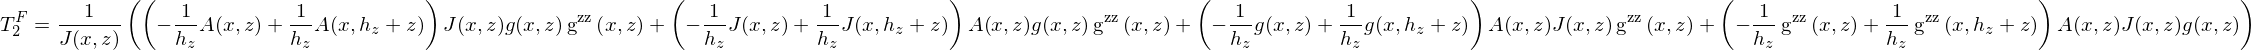

In [9]:
# Define the factors
factors = [J, A, gzz, g]
term2 = finiteDifferenceOfOneTerm(factors, z, forwardZ)
term2 /= J
display(Eq(symbols('T_2^F'), term2))

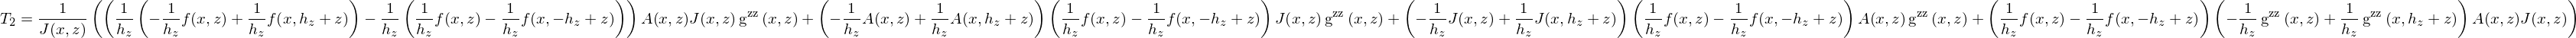

In [10]:
term2 = term2.subs(Subs(g,z,z+hz).doit(), Subs(fzB,z,z+hz).doit())
term2 = term2.subs(g, fzB)
display(Eq(symbols('T_2'), term2))

## Calculating the third term

In [11]:
term3 = B*f
display(Eq(symbols('T_3^F'), term3))

### Collecting terms

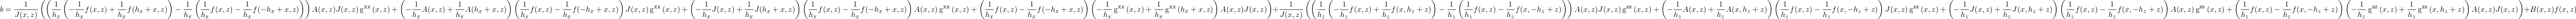

In [12]:
b = term1 + term2 + term3
display(Eq(symbols('b'), b))

In [13]:
# Converting to grid syntax
functions = ['f', 'A', 'J', 'g^x^x', 'g^z^z', 'B']
for func in functions:
    curStr = '{0}_xz, {0}_xp1z, {0}_xm1z, {0}_xzp1, {0}_xzm1'.format(func)
    syms = symbols(curStr)
    b = fromFunctionToGrid(b, syms)

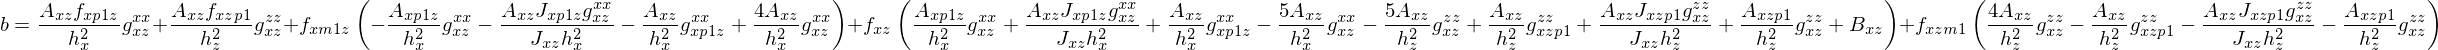

In [14]:
# We must expand before we collect
b = collect(expand(b), symbols('f_xz, f_xp1z, f_xm1z, f_xzp1, f_xzm1'), exact=True)
display(Eq(symbols('b'),b))